In [45]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import sys

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.exceptions import NotFittedError
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, f1_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder

from typing import List, Dict

In [46]:
seed = 0

In [47]:
dataset = pd.read_csv("credit_risk_data_v2.csv")
dataset = dataset.dropna()

class ColumnSelectorTransformer:
    def __init__(self, columns: List[str]):
        self.columns = columns
    
    def transform(self, X: pd.DataFrame, y: pd.DataFrame = None) -> pd.DataFrame:
        return X.loc[:, self.columns]
    
    def fit(self, *args, **kwargs): 
        return self
    
    def __str__(self) -> str:
        return f"ColumnSelectorTransformer({self.columns})"
    
    def __repr__(self) -> str:
        return f"ColumnSelectorTransformer({self.columns})"
    

class BinningTransformer:
    def __init__(self, bins: Dict):
        self.bins = bins
        
    def __find_bin(self, value: float, mappings: List):
        for mapping in mappings:
            if value <= mapping["max"]:
                return mapping["label"]
        return "Error"
        
    def transform(self, X: pd.DataFrame, y: pd.DataFrame = None) -> pd.DataFrame:
        X = X.copy()
        for key in self.bins.keys():
            X.loc[:, key] = X.loc[:, key].transform(lambda x: self.__find_bin(x, self.bins[key]))
        return X

    def fit(self, *args, **kwargs):
        return self
    
    def __str__(self) -> str:
        return "BinningTransformer()"
    
    def __repr__(self) -> str:
        return "BinningTransformer()"

    
class WOETransformer:
    def __init__(self, columns: List[str], target_mappings: Dict = {0: "good", 1: "bad"}):
        self.target_mappings = target_mappings
        self.columns = columns
        self.woe_mappings = None
    
    def __get_absolute_odds(self, df: pd.DataFrame, col: str):
        key_first, key_second = list(self.target_mappings.keys())
        return (
            df.query(f"status=={key_first}")
            .groupby(col).size().reset_index()
            .rename(columns={0: self.target_mappings[key_first]})
            .set_index(col)
        ).join(
            df.query(f"status=={key_second}")
            .groupby(col).size().reset_index()
            .rename(columns={0: self.target_mappings[key_second]})
            .set_index(col)
        ).reset_index()[[col, "good", "bad"]]

    @staticmethod
    def __calculate_relative_odds(row: pd.Series, total_good: int, total_bad: int) -> pd.Series:
        return pd.Series(
            {
                **row.to_dict(),
                "good": row["good"] / total_good,
                "bad": row["bad"] / total_bad
            }
        )

    def __get_odds(self, df: pd.DataFrame, col: str,
                   absolute_values: bool = False) -> pd.DataFrame:
        key_first, key_second = list(self.target_mappings.keys())
        odds_absolute = self.__get_absolute_odds(df, col)

        if absolute_values:
            return odds_absolute

        # Relative Odds
        total_good = odds_absolute["good"].sum()
        total_bad = odds_absolute["bad"].sum()
        return odds_absolute.apply(
            lambda row: WOETransformer.__calculate_relative_odds(row, total_good, total_bad),
            axis=1
        )

    @staticmethod
    def __calculate_woe(row: pd.Series) -> pd.Series:
        return pd.Series(
            {
                **row.to_dict(),
                "woe": np.log(row["good"] / row["bad"]),
                "info_val": (row["good"] - row["bad"]) * np.log(row["good"] / row["bad"])
            }
        )

    def __set_woe_mappings(self, X: pd.DataFrame, y: pd.Series,
                           absolute_values: bool = False) -> None:
        df = X.copy()
        df["status"] = y
        
        self.woe_mappings = {
            col: self.__get_odds(df, col, absolute_values)\
                .apply(lambda row: WOETransformer.__calculate_woe(row), axis=1)\
                .sort_values(by="woe", axis=0, ascending=True)
            for col in self.columns
        }
        
    def fit(self, X: pd.DataFrame, y: pd.DataFrame, *args, **kwargs):
        self.__set_woe_mappings(X, y, *args, **kwargs)
        return self
    
    def transform(self, X: pd.DataFrame, y: pd.DataFrame = None) -> pd.DataFrame:
        if self.woe_mappings is None:
            raise NotFittedError(f"This {self} instance is not fitted yet. Call 'fit' with appropriate arguments before using this transformer.")
        df = X.copy()
        out = pd.DataFrame([])
        for col in df.columns:
            mapping = self.woe_mappings[col].set_index(col)
            categories = list(mapping.index)
            out[col] = df.loc[:, col].apply(lambda cat: mapping.loc[cat, "woe"])
        return out
    
    def __str__(self) -> str:
        return f"WOETransformer(columns={self.columns}, target_mappings={self.target_mappings})"
    
    def __repr__(self) -> str:
        return f"WOETransformer(columns={self.columns}, target_mappings={self.target_mappings})"

In [48]:
from bins import bins

In [49]:
x_train = dataset.drop("status", axis=1)
y_train = dataset["status"]

cols_to_keep = ['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate', 'installment', 
                'annual_inc', 'total_acc', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 
                'total_rec_int', 'last_pymnt_amnt']

## Transformations

In [50]:
column_t = ColumnSelectorTransformer(cols_to_keep)
binning_t = BinningTransformer(bins)
woe_t = WOETransformer(cols_to_keep)

In [51]:
x_train_c = column_t.transform(x_train)
x_train_c.head()

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,total_acc,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,last_pymnt_amnt
0,5000,5000,4975.0,10.65,162.87,24000.0,9.0,5861.071414,5831.78,5000.00,861.07,171.62
1,2500,2500,2500.0,15.27,59.83,30000.0,4.0,1008.710000,1008.71,456.46,435.17,119.66
2,2400,2400,2400.0,15.96,84.33,12252.0,10.0,3003.653644,3003.65,2400.00,603.65,649.91
3,10000,10000,10000.0,13.49,339.31,49200.0,37.0,12226.302210,12226.30,10000.00,2209.33,357.48
4,3000,3000,3000.0,12.69,67.79,80000.0,38.0,3242.170000,3242.17,2233.10,1009.07,67.79


In [52]:
x_train_b = binning_t.transform(x_train_c)
x_train_b.head()

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,total_acc,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,last_pymnt_amnt
0,"(37, 40)","(23, 83)","(29000, 33000)","(558, 1254)","(37, 40)","(29000, 33000)","(-inf, 558)","(37, 40)","(37, 40)","(29000, 33000)","(12, 45)","(558, 1254)"
1,"(37, 40)","(23, 83)","(29000, 33000)","(47000, inf)","(37, 40)","(29000, 33000)","(-inf, 558)","(37, 40)","(37, 40)","(-inf, 29000)","(12, 45)","(558, 1254)"
2,"(37, 40)","(23, 83)","(29000, 33000)","(47000, inf)","(37, 40)","(29000, 33000)","(-inf, 558)","(37, 40)","(37, 40)","(29000, 33000)","(12, 45)","(558, 1254)"
3,"(37, 40)","(23, 83)","(29000, 33000)","(558, 1254)","(37, 40)","(29000, 33000)","(1254, 1597)","(1597, inf)","(1597, inf)","(29000, 33000)","(12, 45)","(558, 1254)"
4,"(37, 40)","(23, 83)","(29000, 33000)","(558, 1254)","(37, 40)","(1597, inf)","(1254, 1597)","(37, 40)","(37, 40)","(29000, 33000)","(12, 45)","(558, 1254)"


In [53]:
woe_t.fit(x_train_b, y_train)

WOETransformer(columns=['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate', 'installment', 'annual_inc', 'total_acc', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'last_pymnt_amnt'], target_mappings={0: 'good', 1: 'bad'})

In [54]:
woe_t.transform(x_train_b).head()

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,total_acc,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,last_pymnt_amnt
0,0.033367,0.0,0.028879,0.279828,0.036495,-0.143224,-0.191810,-0.367055,-0.364306,-0.172076,-0.049672,-0.328884
1,0.033367,0.0,0.028879,-0.416729,0.036495,-0.143224,-0.191810,-0.367055,-0.364306,-2.855896,-0.049672,-0.328884
2,0.033367,0.0,0.028879,-0.416729,0.036495,-0.143224,-0.191810,-0.367055,-0.364306,-0.172076,-0.049672,-0.328884
3,0.033367,0.0,0.028879,0.279828,0.036495,-0.143224,0.080964,0.915543,0.922470,-0.172076,-0.049672,-0.328884
4,0.033367,0.0,0.028879,0.279828,0.036495,0.275222,0.080964,-0.367055,-0.364306,-0.172076,-0.049672,-0.328884


## WOE

Now that we transformer our data to the respective Weight of Evidence, we can get the mappings for a given column to analyze the WoE and IV, and determine if our bins have a good predictive power, or if we need to re-structure them.

In [55]:
woe_t.woe_mappings["loan_amnt"]

,loan_amnt,good,bad,woe,info_val
1,"(40, 46)",0.443323,0.461591,-0.040382,0.000738
0,"(37, 40)",0.556677,0.538409,0.033367,0.000610


In [56]:
woe_t.woe_mappings["funded_amnt"]

,funded_amnt,good,bad,woe,info_val
0,"(23, 83)",1.0,1.0,0.0,0.0


In [57]:
woe_t.woe_mappings["funded_amnt_inv"]

,funded_amnt_inv,good,bad,woe,info_val
0,"(-inf, 29000)",0.000963,0.003355,-1.248039,0.002985
2,"(33000, 42000)",0.440147,0.453664,-0.030249,0.000409
1,"(29000, 33000)",0.558890,0.542980,0.028879,0.000459


In [60]:
woe_t.woe_mappings["int_rate"]

,int_rate,good,bad,woe,info_val
1,"(47000, inf)",0.437026,0.662965,-0.416729,0.094155
2,"(558, 1254)",0.342348,0.258785,0.279828,0.023383
0,"(-inf, 29000)",0.220626,0.078250,1.036563,0.147582


In [61]:
woe_t.woe_mappings["installment"]

,installment,good,bad,woe,info_val
1,"(40, 46)",0.41842,0.439262,-0.048611,0.001013
0,"(37, 40)",0.58158,0.560738,0.036495,0.000761


In [62]:
woe_t.woe_mappings["annual_inc"]

,annual_inc,good,bad,woe,info_val
1,"(29000, 33000)",0.609746,0.70364,-0.143224,0.013448
0,"(1597, inf)",0.390254,0.29636,0.275222,0.025842


In [63]:
woe_t.woe_mappings["total_acc"]

,total_acc,good,bad,woe,info_val
0,"(-inf, 558)",0.075460,0.091416,-0.191810,0.003060
2,"(558, 1254)",0.490254,0.508074,-0.035704,0.000636
1,"(1254, 1597)",0.434286,0.400510,0.080964,0.002735


In [64]:
woe_t.woe_mappings["total_pymnt"]

,total_pymnt,good,bad,woe,info_val
1,"(37, 40)",0.574879,0.829824,-0.367055,0.093579
0,"(1597, inf)",0.425121,0.170176,0.915543,0.233414


In [65]:
woe_t.woe_mappings["total_pymnt_inv"]

,total_pymnt_inv,good,bad,woe,info_val
1,"(37, 40)",0.578192,0.832316,-0.364306,0.092579
0,"(1597, inf)",0.421808,0.167684,0.922470,0.234422


In [66]:
woe_t.woe_mappings["total_rec_prncp"]

,total_rec_prncp,good,bad,woe,info_val
0,"(-inf, 29000)",0.009767,0.169842,-2.855896,0.457159
2,"(29000, 33000)",0.649595,0.771569,-0.172076,0.020989
1,"(1597, inf)",0.340638,0.058589,1.760270,0.496482


In [67]:
woe_t.woe_mappings["total_rec_int"]

,total_rec_int,good,bad,woe,info_val
0,"(12, 45)",0.651806,0.685,-0.049672,0.001649
1,"(45, 71)",0.348194,0.315,0.100187,0.003326


In [68]:
woe_t.woe_mappings["last_pymnt_amnt"]

,last_pymnt_amnt,good,bad,woe,info_val
1,"(558, 1254)",0.717947,0.997528,-0.328884,0.091950
0,"(1597, inf)",0.282053,0.002472,4.736952,1.324359


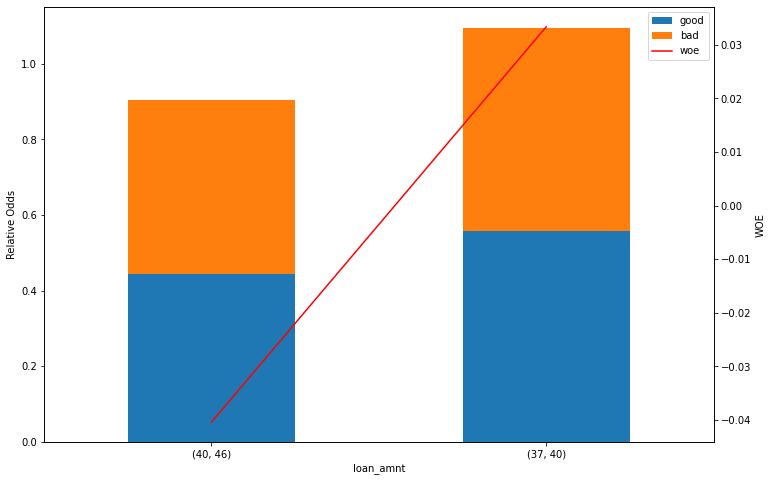

In [71]:
ax = woe_t.woe_mappings["loan_amnt"].plot.bar(
    x="loan_amnt", y=["good", "bad"], figsize=(12, 8), stacked=True
)

woe_t.woe_mappings["loan_amnt"].plot(
    x="loan_amnt", y="woe", ax=ax, secondary_y=True, mark_right=False, c="r"
)

ax.right_ax.set_ylabel("WOE")
ax.set_ylabel("Relative Odds");

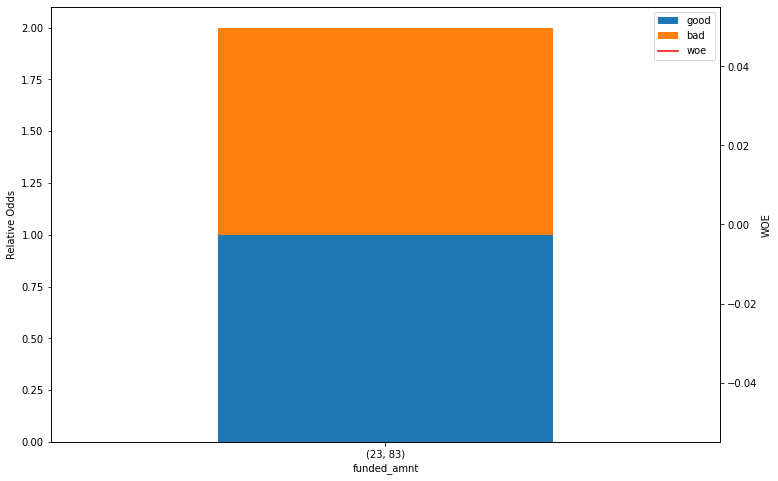

In [72]:
ax = woe_t.woe_mappings["funded_amnt"].plot.bar(
    x="funded_amnt", y=["good", "bad"], figsize=(12, 8), stacked=True
)

woe_t.woe_mappings["funded_amnt"].plot(
    x="funded_amnt", y="woe", ax=ax, secondary_y=True, mark_right=False, c="r"
)

ax.right_ax.set_ylabel("WOE")
ax.set_ylabel("Relative Odds");

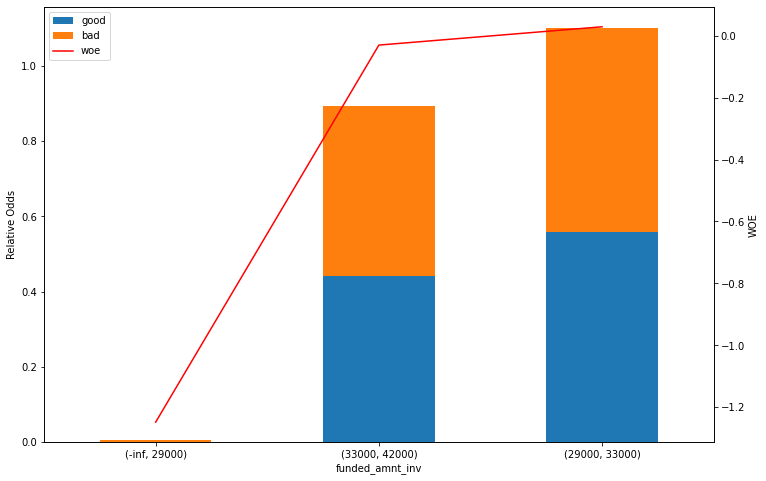

In [73]:
ax = woe_t.woe_mappings["funded_amnt_inv"].plot.bar(
    x="funded_amnt_inv", y=["good", "bad"], figsize=(12, 8), stacked=True
)

woe_t.woe_mappings["funded_amnt_inv"].plot(
    x="funded_amnt_inv", y="woe", ax=ax, secondary_y=True, mark_right=False, c="r"
)

ax.right_ax.set_ylabel("WOE")
ax.set_ylabel("Relative Odds");

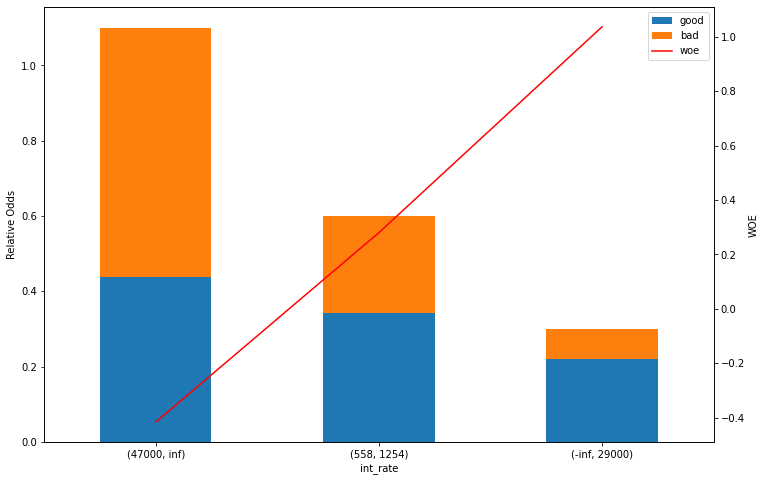

In [74]:
ax = woe_t.woe_mappings["int_rate"].plot.bar(
    x="int_rate", y=["good", "bad"], figsize=(12, 8), stacked=True
)

woe_t.woe_mappings["int_rate"].plot(
    x="int_rate", y="woe", ax=ax, secondary_y=True, mark_right=False, c="r"
)

ax.right_ax.set_ylabel("WOE")
ax.set_ylabel("Relative Odds");

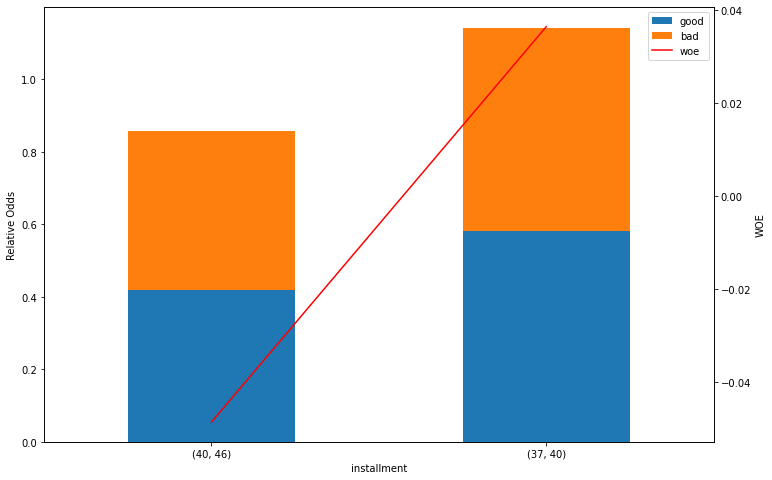

In [75]:
ax = woe_t.woe_mappings["installment"].plot.bar(
    x="installment", y=["good", "bad"], figsize=(12, 8), stacked=True
)

woe_t.woe_mappings["installment"].plot(
    x="installment", y="woe", ax=ax, secondary_y=True, mark_right=False, c="r"
)

ax.right_ax.set_ylabel("WOE")
ax.set_ylabel("Relative Odds");

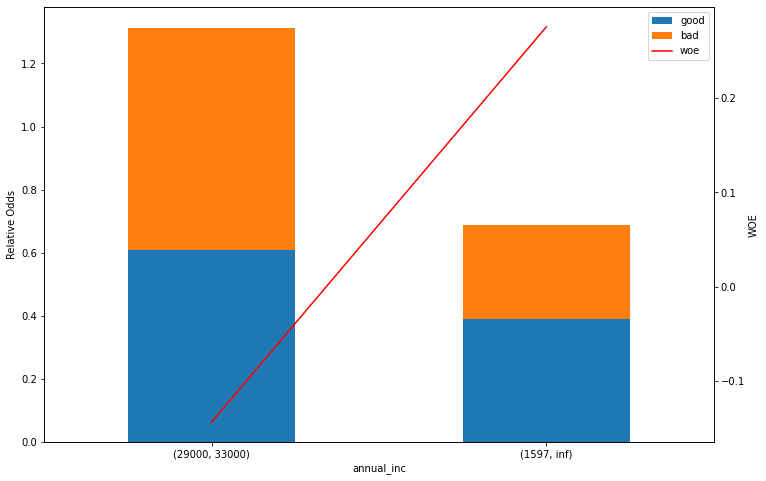

In [76]:
ax = woe_t.woe_mappings["annual_inc"].plot.bar(
    x="annual_inc", y=["good", "bad"], figsize=(12, 8), stacked=True
)

woe_t.woe_mappings["annual_inc"].plot(
    x="annual_inc", y="woe", ax=ax, secondary_y=True, mark_right=False, c="r"
)

ax.right_ax.set_ylabel("WOE")
ax.set_ylabel("Relative Odds");

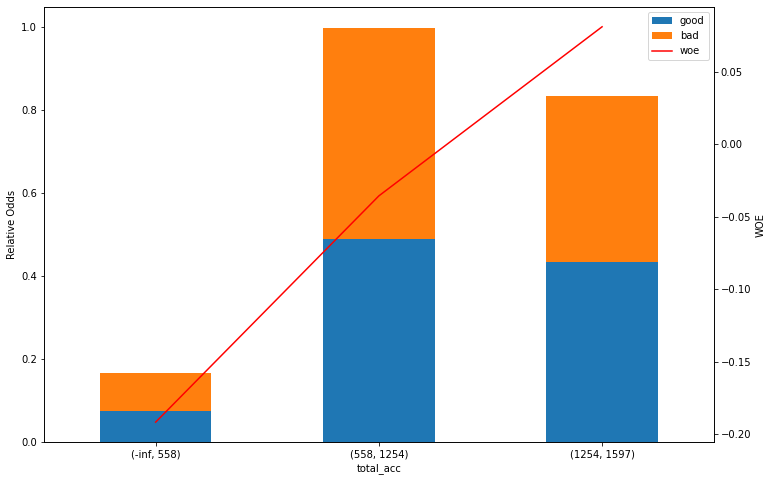

In [77]:
ax = woe_t.woe_mappings["total_acc"].plot.bar(
    x="total_acc", y=["good", "bad"], figsize=(12, 8), stacked=True
)

woe_t.woe_mappings["total_acc"].plot(
    x="total_acc", y="woe", ax=ax, secondary_y=True, mark_right=False, c="r"
)

ax.right_ax.set_ylabel("WOE")
ax.set_ylabel("Relative Odds");

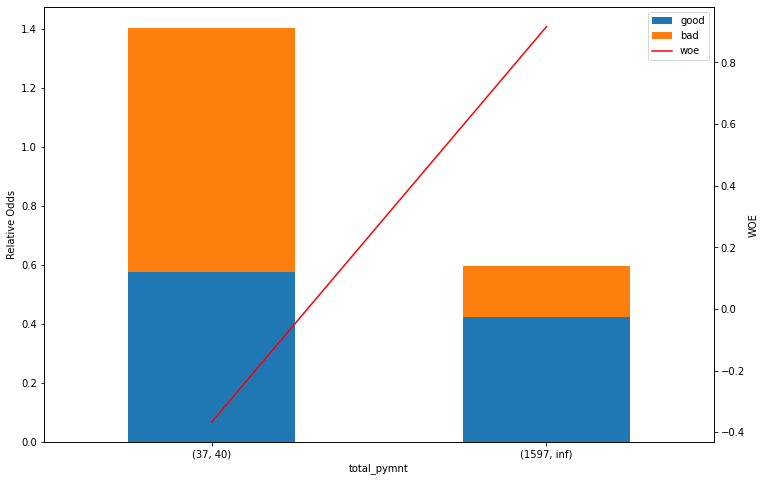

In [78]:
ax = woe_t.woe_mappings["total_pymnt"].plot.bar(
    x="total_pymnt", y=["good", "bad"], figsize=(12, 8), stacked=True
)

woe_t.woe_mappings["total_pymnt"].plot(
    x="total_pymnt", y="woe", ax=ax, secondary_y=True, mark_right=False, c="r"
)

ax.right_ax.set_ylabel("WOE")
ax.set_ylabel("Relative Odds");

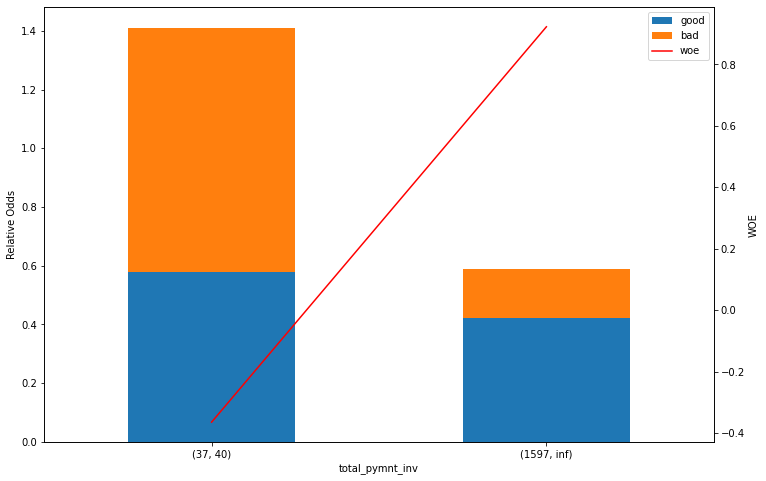

In [79]:
ax = woe_t.woe_mappings["total_pymnt_inv"].plot.bar(
    x="total_pymnt_inv", y=["good", "bad"], figsize=(12, 8), stacked=True
)

woe_t.woe_mappings["total_pymnt_inv"].plot(
    x="total_pymnt_inv", y="woe", ax=ax, secondary_y=True, mark_right=False, c="r"
)

ax.right_ax.set_ylabel("WOE")
ax.set_ylabel("Relative Odds");

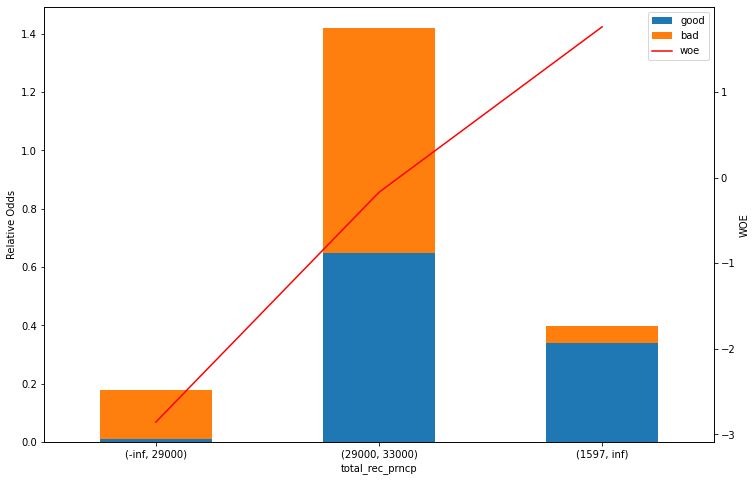

In [80]:
ax = woe_t.woe_mappings["total_rec_prncp"].plot.bar(
    x="total_rec_prncp", y=["good", "bad"], figsize=(12, 8), stacked=True
)

woe_t.woe_mappings["total_rec_prncp"].plot(
    x="total_rec_prncp", y="woe", ax=ax, secondary_y=True, mark_right=False, c="r"
)

ax.right_ax.set_ylabel("WOE")
ax.set_ylabel("Relative Odds");

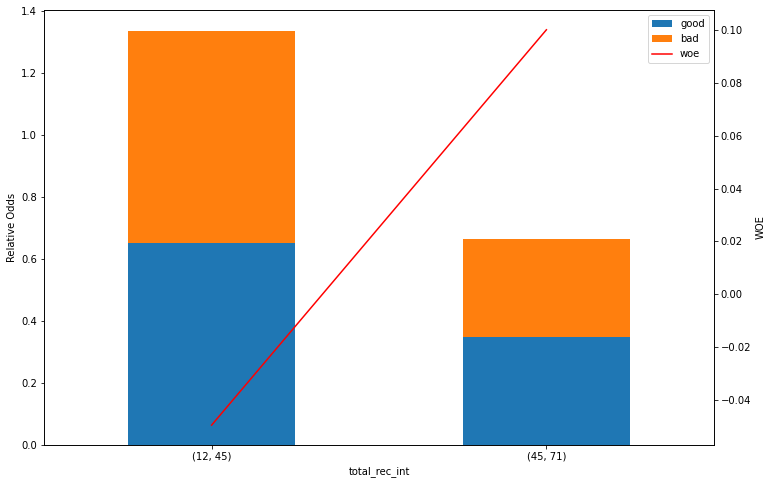

In [81]:
ax = woe_t.woe_mappings["total_rec_int"].plot.bar(
    x="total_rec_int", y=["good", "bad"], figsize=(12, 8), stacked=True
)

woe_t.woe_mappings["total_rec_int"].plot(
    x="total_rec_int", y="woe", ax=ax, secondary_y=True, mark_right=False, c="r"
)

ax.right_ax.set_ylabel("WOE")
ax.set_ylabel("Relative Odds");

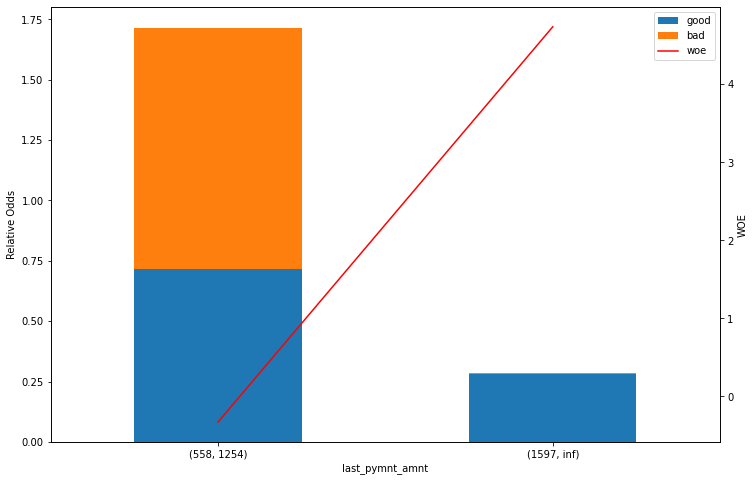

In [82]:
ax = woe_t.woe_mappings["last_pymnt_amnt"].plot.bar(
    x="last_pymnt_amnt", y=["good", "bad"], figsize=(12, 8), stacked=True
)

woe_t.woe_mappings["last_pymnt_amnt"].plot(
    x="last_pymnt_amnt", y="woe", ax=ax, secondary_y=True, mark_right=False, c="r"
)

ax.right_ax.set_ylabel("WOE")
ax.set_ylabel("Relative Odds");

# Pipelines

We already defined our custom transformers, and since we added a `fit` and `transform` method, we are able to use `sklearn.pipelines` to stack the transformers and models into a single job that is dealing with raw data. 

In [83]:
ml_pipe = Pipeline([
    ('col selector', ColumnSelectorTransformer(columns=cols_to_keep)),
    ('bins', BinningTransformer(bins=bins)),
    ('woe', WOETransformer(columns=cols_to_keep)),
    # ('logistic regression', LogisticRegression(random_state=seed))
    ('gdbt', GradientBoostingClassifier(random_state=seed))
])

In [84]:
y_train_nd = [1 if val==0 else 0 for val in y_train.values]

In [85]:
ml_pipe.fit(x_train, y_train_nd)

Pipeline(steps=[('col selector',
                 ColumnSelectorTransformer(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate', 'installment', 'annual_inc', 'total_acc', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'last_pymnt_amnt'])),
                ('bins', BinningTransformer()),
                ('woe',
                 WOETransformer(columns=['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate', 'installment', 'annual_inc', 'total_acc', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'last_pymnt_amnt'], target_mappings={0: 'good', 1: 'bad'})),
                ('gdbt', GradientBoostingClassifier(random_state=0))])

In [86]:
ml_pipe.score(x_train, y_train_nd)

0.9058993342713016

In [87]:
ml_pipe.predict_proba(x_train)

array([[0.09879666, 0.90120334],
       [0.67107342, 0.32892658],
       [0.16208031, 0.83791969],
       ...,
       [0.19320353, 0.80679647],
       [0.03985886, 0.96014114],
       [0.11268518, 0.88731482]])

In [88]:
y_pred = ml_pipe.predict(x_train)

In [89]:
fpr, tpr, threshold = roc_curve(y_train_nd, ml_pipe.predict_proba(x_train)[:, 1])
roc_auc = auc(fpr, tpr)
f1 = f1_score(y_train_nd, y_pred)
print(f"ROC AUC: {roc_auc}")
print(f"F1: {f1}")

ROC AUC: 0.8233409771546927
F1: 0.9493336289593388


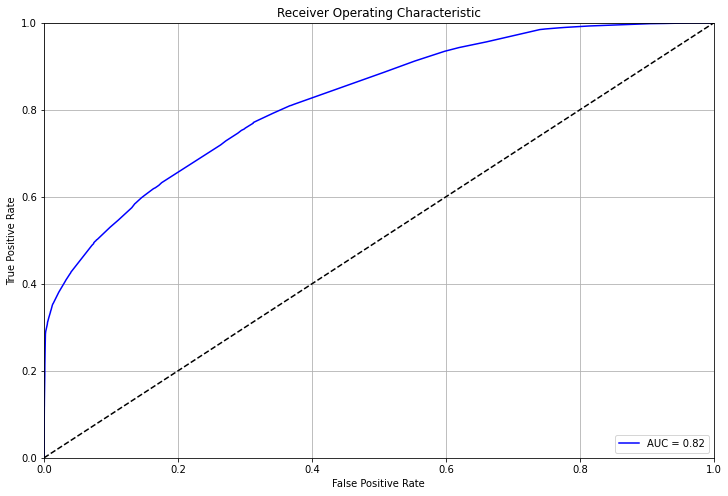

In [90]:
plt.figure(figsize=(12, 8))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'k--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.grid()
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [91]:
predictions = pd.DataFrame({"y_original": y_train_nd, "y_predicted": ml_pipe.predict_proba(x_train)[:, 1]})
predictions.head()

,y_original,y_predicted
0,1,0.901203
1,0,0.328927
2,1,0.837920
3,1,0.964864
4,1,0.919803


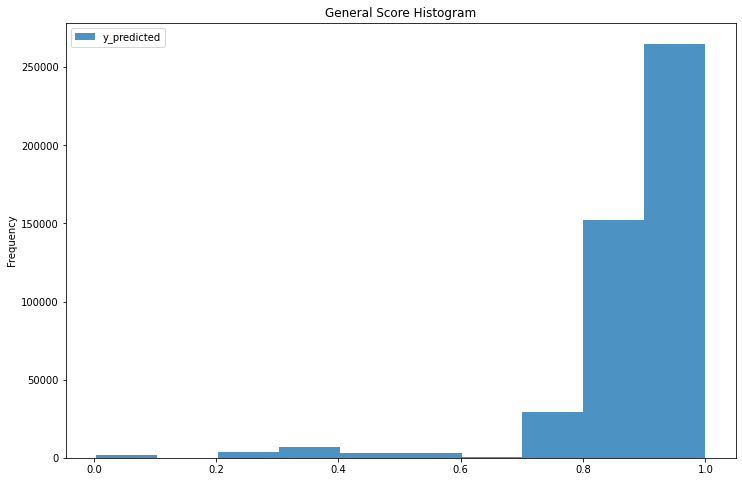

In [92]:
predictions.plot.hist(title="General Score Histogram", y="y_predicted", 
                      bins=10, alpha=0.8, figsize=(12, 8));

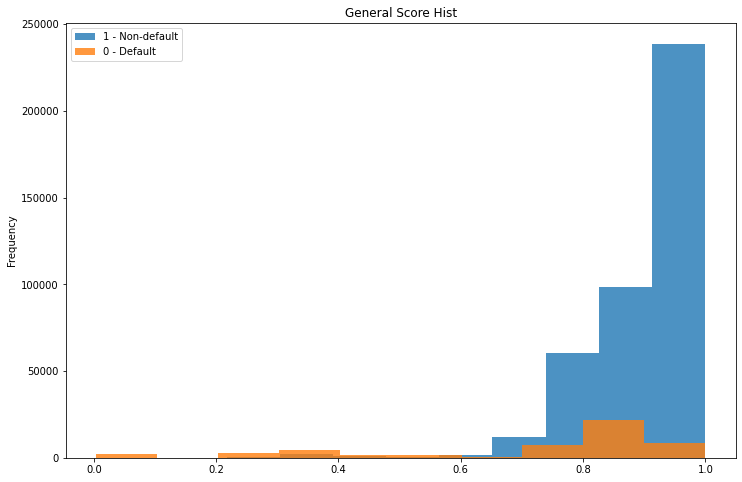

In [93]:
fig, ax = plt.subplots(figsize=(12, 8))

predictions[predictions["y_original"] == 1].plot.hist(title="General Score Hist",
                                                      y="y_predicted",
                                                      bins=10,
                                                      alpha=0.8,
                                                      ax=ax,
                                                      label="1 - Non-default")

predictions[predictions["y_original"] == 0].plot.hist(title="General Score Hist",
                                                      y="y_predicted",
                                                      bins=10,
                                                      alpha=0.8,
                                                      ax=ax,
                                                      label="0 - Default");


In [94]:
predictions[predictions["y_original"] == 0].mean()

y_original     0.000000
y_predicted    0.709655
dtype: float64

In [95]:
predictions[predictions["y_original"] == 1].mean()

y_original     1.000000
y_predicted    0.912896
dtype: float64